In [278]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import shap
import pickle

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

<h1 style="text-align:center">Dataset Loading</h1>

In [279]:
def read_data():
    df = pd.read_csv("./input/telomere_health.csv")
    df = df.drop(
        columns=[
            "socioeconomic_status",
            "bp",
            "bmi_category",
            "hr_category",
            "rr_category",
            "health_condition",
            "education_cohort",
            "marital_status"

        ]
    )
    return df


def categorical_to_numeric(df, column, mapping, regex=False):
    df[column] = df[column].replace(mapping, regex=regex)


def fill_na(df, column, default):
    fill_value = np.nan
    if default == "median":
        fill_value = df[column].median()
    elif default == "mode":
        fill_value = df[column].mode()[0]

    df[column] = df[column].fillna(fill_value)

<h1 style="text-align:center">Data Preprocessing</h1>

In [280]:
def preprocess_data(df):

    categorical_to_numeric(
        df,
        "cigarette_smoking",
        {
            "No information": np.nan,
            "Former Smoker": np.nan,
            "Never Smoker": 0,
            "Occasional Smoker": 1,
            "Regular Smoker": 2,
        },
    )

    categorical_to_numeric(
        df,
        "physical_activity_cohort",
        {
            "No information": np.nan,
            "Sedentary (Inactive)": 0,
            "Minimally Active": 1,
            "Lightly Active": 2,
            "Moderately Active": 3,
            "Highly Active": 4,
        },
    )

    categorical_to_numeric(
        df,
        "alcohol_drinking",
        {
            "No information": np.nan,
            "Former Drinker": np.nan,
            "Never Drinker": 0,
            "Occasional Drinker": 1,
            "Moderate Drinker": 2,
            "Heavy Drinker": 3,
        },
    )
    
    categorical_to_numeric(
        df,
        "bp_category",
        {
            "No information": np.nan,
            "Hypotension (Low BP)": 0,
            "Normal BP": 1,
            "Elevated BP": 2,
            "Hypertension Stage 1": 3,
            "Hypertension Stage 2": 4,
            "Hypertensive Crisis": 5,
        },
    )

    categorical_to_numeric(
        df,
        "cardiovascular_disease_diagnosis",
        {
            "^No known*": 0,
            "^Non-cardiovascular*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "cancer_diagnosis",
        {
            "^Clinically Healthy*": 0,
            "^Non-oncologic*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "depression_anxiety_diagnosis",
        {
            "^No Known*": 0,
            "^Anxiety and/or*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "allergy_diagnosis",
        {
            "^No Diagnosed*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "diabetes_diagnosis",
        {
            "^No known diagnosis*": 0,
            "^Diagnosed with*": 1,
        },
        regex=True,
    )

    df["hr"] = pd.to_numeric(df["hr"], errors="coerce")
    df["rr"] = pd.to_numeric(df["rr"], errors="coerce")

    fill_na(df, "hr", "median")
    fill_na(df, "rr", "median")
    fill_na(df, "bmi", "median")
    fill_na(df, "alcohol_drinking", "mode")
    fill_na(df, "cigarette_smoking", "mode")
    fill_na(df, "bp_category", "mode")
    fill_na(df, "physical_activity_cohort", "mode")

    df = pd.get_dummies(df, columns=["sex"])

    return df

<h1 style="text-align:center">Model Training</h1>

In [512]:
def train_model(df, to_predict):
    y = df.pop(to_predict)
    X = df

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    # Feature Selection
    selector = VarianceThreshold(threshold=0.45)  # (0.8 * (1 - 0.8)))

    X_train_selected = selector.fit_transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Scaling and Training Pipeline

    pipeline = Pipeline(
        [("scaler", StandardScaler()), ("lsvc", SVC(kernel="linear", probability=True))]
    )
    pipeline.fit(X_train_selected, y_train)

    # ~Scores and Metrics~

    # Feature Variance, Weights, and Shapley
    scaler = pipeline.named_steps["scaler"]

    selected_weights = np.array(pipeline.named_steps["lsvc"].coef_[0])
    selected_features = X_train.columns[selector.get_support()]
    selected_variances = selector.variances_[selector.get_support()]

    explainer = shap.LinearExplainer(
        pipeline.named_steps["lsvc"], scaler.transform(X_train_selected)
    )
    shap_values = explainer.shap_values(scaler.transform(X_test_selected))

    feature_vw = pd.DataFrame(
        data={
            "Selected Features": selected_features,
            "Variances": selected_variances,
            "Weights": selected_weights,
        }
    )

    # Prediction Accuracy
    score = pipeline.score(X_test_selected, y_test)
    probabilties = np.array(pipeline.predict_proba(X_test_selected)[:, 1])
    y_prediction = pipeline.predict(X_test_selected)

    prediction_df = pd.DataFrame(
        data={
            "Actual": y_test.reset_index(drop=True).map({1: "Present", 0: "Absent"}),
            "Predicted": pd.Series(y_prediction)
            .reset_index(drop=True)
            .map({1: "Present", 0: "Absent"}),
            "Probability (%)": np.round(probabilties * 100, decimals=2),
            "Match": pd.Series((y_prediction == y_test).astype(bool))
            .reset_index(drop=True)
            .map({True: "Correct", False: "Incorrect"}),
        }
    )

    prediction_df["Accuracy"] = pd.Series(round(score * 100, 2))

    return (pipeline, feature_vw, shap_values, prediction_df.fillna(""))

<h1 style="text-align:center">Model Assessment</h1>

<h2 style="text-align:center">Cardiovascular Disease Prediction</h1>

In [513]:
cvd_df = read_data()
cvd_df_preprocessed = preprocess_data(cvd_df)

cvd_pipeline, cvd_feature_vw, cvd_shap_values, cvd_prediction_df = train_model(
    cvd_df_preprocessed, to_predict="cardiovascular_disease_diagnosis"
)

In [514]:
cvd_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,66.585122,0.000455
1,age,350.848368,0.913314
2,alcohol_drinking,0.603300,0.055720
3,physical_activity_cohort,1.741588,-0.165058
4,bmi,404.932442,0.010207
5,hr,117.520405,0.121417
6,rr,3.827612,0.144062
7,bp_category,1.085276,0.469888


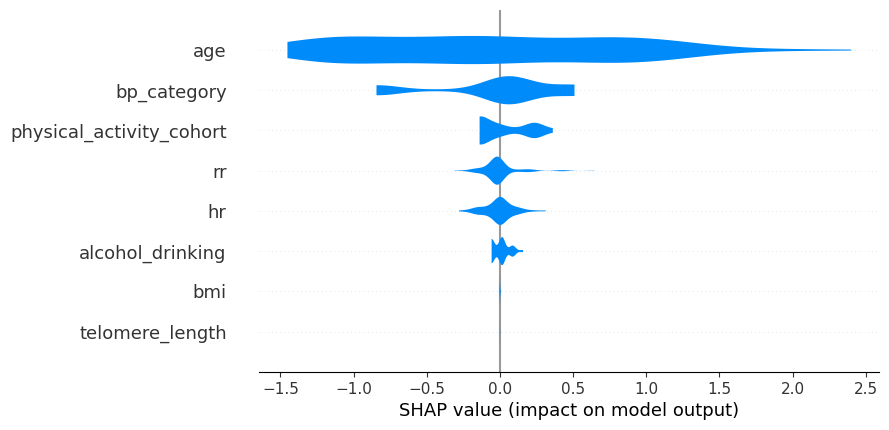

In [515]:
shap.plots.violin(cvd_shap_values, feature_names=cvd_feature_vw["Selected Features"])

In [516]:
def match_highlight(value):
    color = "green" if value == "Correct" else "red" if value == "Incorrect" else None
    return f"background-color: {color}; color: white"


cvd_prediction_df = cvd_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_cvd_prediction_df = cvd_prediction_df.head(10).style.applymap(match_highlight)

display(styled_cvd_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Absent,Absent,4.25,Correct,79.87
1,Absent,Absent,17.53,Correct,
2,Absent,Absent,5.91,Correct,
3,Absent,Absent,5.17,Correct,
4,Absent,Absent,29.26,Correct,
5,Absent,Absent,10.03,Correct,
6,Present,Present,68.87,Correct,
7,Absent,Absent,36.36,Correct,
8,Present,Present,50,Correct,
9,Absent,Absent,41.14,Correct,


<h2 style="text-align:center">Cancer Prediction</h1>

In [517]:
cancer_df = read_data()
cancer_df_preprocessed = preprocess_data(cancer_df)

cancer_pipeline, cancer_feature_vw, cancer_shap_values, cancer_prediction_df = train_model(
    cancer_df_preprocessed, to_predict="cancer_diagnosis"
)

In [518]:
cancer_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,65.506179,3.319451e-05
1,age,349.169202,-4.251466e-07
2,alcohol_drinking,0.604778,6.419951e-06
3,physical_activity_cohort,1.803314,-1.466988e-05
4,bmi,404.564407,-4.201288e-05
5,hr,110.010399,6.269553e-06
6,rr,3.336696,-2.746475e-05
7,bp_category,1.086255,1.790719e-05


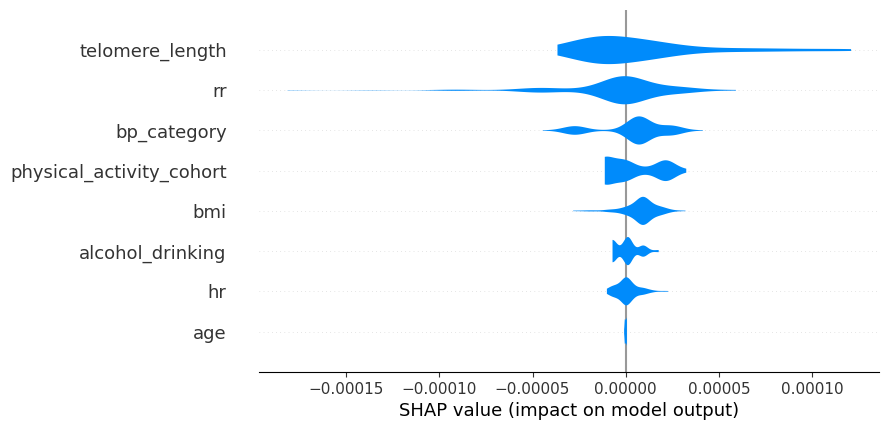

In [519]:
shap.plots.violin(cancer_shap_values, feature_names=cancer_feature_vw["Selected Features"])

In [520]:
cancer_prediction_df = cancer_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_cancer_prediction_df = cancer_prediction_df.head(10).style.applymap(
    match_highlight
)

display(styled_cancer_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Absent,Absent,18.78,Correct,86.36
1,Absent,Absent,18.86,Correct,
2,Absent,Absent,19.33,Correct,
3,Absent,Absent,18.76,Correct,
4,Absent,Absent,24.3,Correct,
5,Absent,Absent,30.35,Correct,
6,Absent,Absent,17.98,Correct,
7,Absent,Absent,20.74,Correct,
8,Absent,Absent,22.4,Correct,
9,Absent,Absent,21.03,Correct,


<h2 style="text-align:center">Diabetes Mellitus Prediction</h1>

In [521]:
diabetes_df = read_data()
diabetes_df_preprocessed = preprocess_data(diabetes_df)

diabetes_pipeline, diabetes_feature_vw, diabetes_shap_values, diabetes_prediction_df = train_model(
    diabetes_df_preprocessed, to_predict="diabetes_diagnosis"
)

In [522]:
diabetes_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,60.128099,0.002270
1,age,340.297298,0.011538
2,alcohol_drinking,0.620654,0.003311
3,physical_activity_cohort,1.740214,0.000869
4,bmi,404.312582,0.095963
5,hr,105.585528,-0.001154
6,rr,3.527962,-0.003892
7,bp_category,1.033470,-0.000675


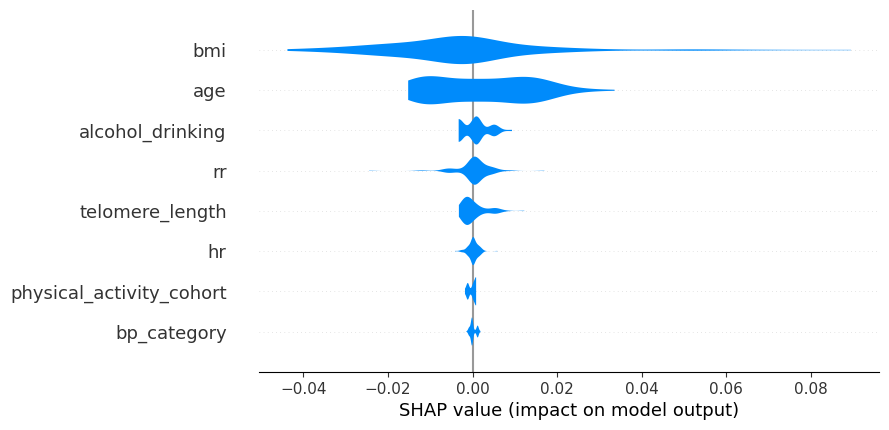

In [523]:
shap.plots.violin(diabetes_shap_values, feature_names=diabetes_feature_vw["Selected Features"])

In [524]:
diabetes_prediction_df = diabetes_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_diabetes_prediction_df = diabetes_prediction_df.head(10).style.applymap(
    match_highlight
)

display(styled_diabetes_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Absent,Absent,9.3,Correct,95.45
1,Absent,Absent,8.39,Correct,
2,Absent,Absent,6.24,Correct,
3,Absent,Absent,8.03,Correct,
4,Absent,Absent,10,Correct,
5,Absent,Absent,6.04,Correct,
6,Absent,Absent,6.3,Correct,
7,Absent,Absent,6.89,Correct,
8,Absent,Absent,10.52,Correct,
9,Absent,Absent,7.8,Correct,


<h2 style="text-align:center">Depression/Anxiety Prediction</h1>

In [525]:
depression_anxiety_df = read_data()
depression_anxiety_df_preprocessed = preprocess_data(depression_anxiety_df)

(
    depression_anxiety_pipeline,
    depression_anxiety_feature_vw,
    depression_anxiety_shap_values,
    depression_anxiety_prediction_df,
) = train_model(
    depression_anxiety_df_preprocessed, to_predict="depression_anxiety_diagnosis"
)

In [526]:
depression_anxiety_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,67.577817,-0.000030
1,age,352.581081,-0.000230
2,alcohol_drinking,0.625030,0.000083
3,physical_activity_cohort,1.767242,-0.000043
4,bmi,16.358738,-0.000001
5,hr,92.397617,-0.000067
6,rr,3.493358,-0.000027
7,bp_category,1.009199,0.000210


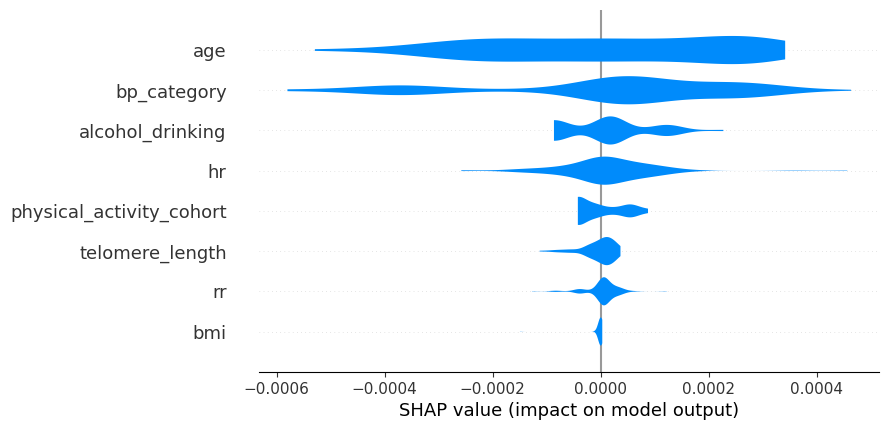

In [527]:
shap.plots.violin(depression_anxiety_shap_values, feature_names=depression_anxiety_feature_vw["Selected Features"])

In [528]:
depression_anxiety_prediction_df = depression_anxiety_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_depression_anxiety_prediction_df = depression_anxiety_prediction_df.head(
    10
).style.applymap(match_highlight)

display(styled_depression_anxiety_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Absent,Absent,16.38,Correct,90.26
1,Absent,Absent,7.73,Correct,
2,Absent,Absent,9.1,Correct,
3,Absent,Absent,10.87,Correct,
4,Absent,Absent,12.85,Correct,
5,Absent,Absent,16.76,Correct,
6,Absent,Absent,13.61,Correct,
7,Absent,Absent,10.05,Correct,
8,Absent,Absent,5.81,Correct,
9,Absent,Absent,11.38,Correct,


<h2 style="text-align:center">Allergy Prediction</h1>

In [529]:
allergy_df = read_data()
allergy_df_preprocessed = preprocess_data(allergy_df)

(
    allergy_pipeline,
    allergy_feature_vw,
    allergy_shap_values,
    allergy_prediction_df,
) = train_model(allergy_df_preprocessed, to_predict="allergy_diagnosis")

In [530]:
allergy_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,63.683115,0.000009
1,age,353.586902,-0.000054
2,alcohol_drinking,0.619176,-0.000015
3,physical_activity_cohort,1.794034,0.000082
4,bmi,406.181607,0.000003
5,hr,103.432593,-0.000009
6,rr,3.902184,-0.000035
7,bp_category,1.075950,0.000031


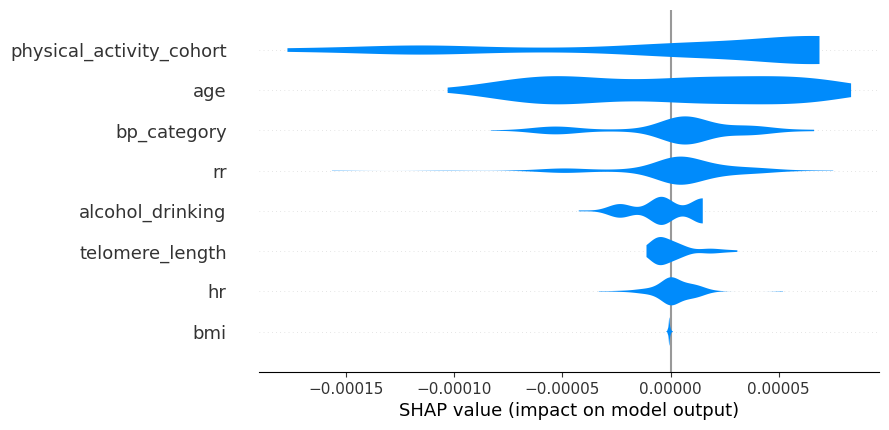

In [531]:
shap.plots.violin(allergy_shap_values, feature_names=allergy_feature_vw["Selected Features"])

In [532]:
allergy_prediction_df = allergy_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_allergy_prediction_df = allergy_prediction_df.head(10).style.applymap(
    match_highlight
)

display(styled_allergy_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Absent,Absent,14.62,Correct,90.26
1,Absent,Absent,14.57,Correct,
2,Present,Absent,13.7,Incorrect,
3,Absent,Absent,14.62,Correct,
4,Absent,Absent,14.23,Correct,
5,Absent,Absent,15.02,Correct,
6,Absent,Absent,13.74,Correct,
7,Absent,Absent,14.83,Correct,
8,Present,Absent,14.56,Incorrect,
9,Absent,Absent,14.07,Correct,
